<a href="https://colab.research.google.com/github/wgrzyb/PJN_L1/blob/main/PJN_L1_TFIDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Zadanie laboratoryjne nr 1 - TFIDF

Wykonał: Wojciech Grzyb

Grupa: WCY19KB2S4

---

1. Utworzyć korpus dokumentów na podstawie 5-10 książek pobranych ze strony Wolne Lektury: https://wolnelektury.pl/
2. Dla każdej z pozycji zwizualizować częstość występowania tokenów i skomentować zgodność z prawem Zipfa. Jako tokeny przyjmujemy tylko tokeny zbudowane wyłącznie z liter.
Zastosować stoplistę  dla języka polskiego.
3. Na podstawie korpusu zbudowanego   z 5 dowolnych książek ściągniętych ze strony Wolne Lektury zbudować macierz tfidf.  
4. W oparciu o podobieństwo kosinusowe zbudować macierz odległości dokumentów. 
5. Przeprowadzić redukcję wymiarowości wymiarów macierzy tf-idf do 2 wymiarów  i zwizualizować położenie dokumentów na układzie współrzędnych.  
6. Skomentować spójność wyników z punktu 4 i 5. Które dokumenty są najbardziej podobne do siebie  w obydwu wariantach?

---


1) Przygotowanie korpusu dokumentów:

In [1]:
import requests

corpus = {
    'boska-komedia': 'https://wolnelektury.pl/media/book/txt/boska-komedia-raj.txt',
    'kordian': 'https://wolnelektury.pl/media/book/txt/kordian.txt',
    'przedwiosnie': 'https://wolnelektury.pl/media/book/txt/przedwiosnie.txt',
    'wesele': 'https://wolnelektury.pl/media/book/txt/wesele.txt',
    'zemsta': 'https://wolnelektury.pl/media/book/txt/zemsta.txt'
}

# Pobranie dokumentów
documents = []
for pos in corpus:
  r = requests.get(corpus.get(pos))
  documents.append(r.text)

# Wypisanie pozycji korpusu:
print('Korpus:')
for pos in corpus:
  print(f' * {pos}')


Korpus:
 * boska-komedia
 * kordian
 * przedwiosnie
 * wesele
 * zemsta


2) Wizualizacja częstości występowania tokenów dla każdej pozycji z korpusu:

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


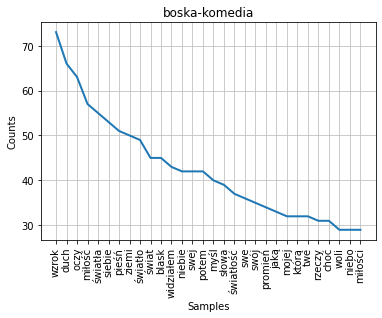

Prawo Zipfa:
 r*f=[73, 132, 189, 228, 275, 318, 357, 400, 441, 450, 495, 516, 546, 588, 630, 640, 663, 666, 684, 700, 714, 726, 736, 768, 800, 806, 837, 812, 841, 870]
 average=563.3666666666667


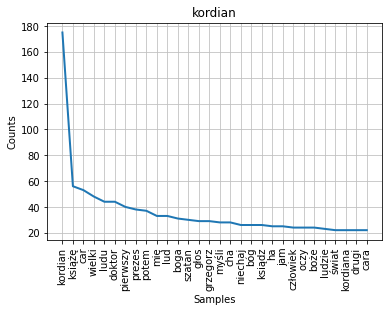

Prawo Zipfa:
 r*f=[175, 112, 159, 192, 220, 264, 280, 304, 333, 330, 363, 372, 390, 406, 435, 448, 476, 468, 494, 520, 525, 550, 552, 576, 600, 598, 594, 616, 638, 660]
 average=421.6666666666667


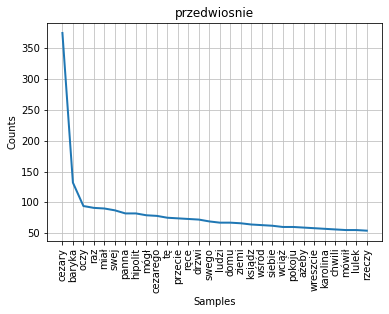

Prawo Zipfa:
 r*f=[375, 264, 282, 364, 450, 522, 574, 656, 711, 780, 825, 888, 949, 1008, 1035, 1072, 1139, 1188, 1216, 1260, 1302, 1320, 1380, 1416, 1450, 1482, 1512, 1540, 1595, 1620]
 average=1005.8333333333334


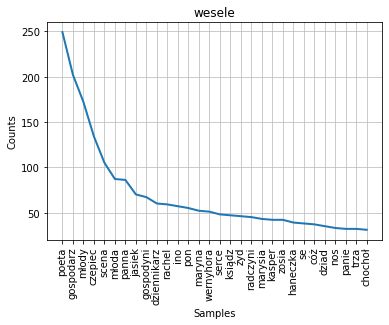

Prawo Zipfa:
 r*f=[249, 404, 516, 536, 525, 522, 602, 560, 603, 600, 649, 684, 715, 728, 765, 768, 799, 828, 855, 860, 882, 924, 897, 912, 925, 910, 891, 896, 928, 930]
 average=728.7666666666667


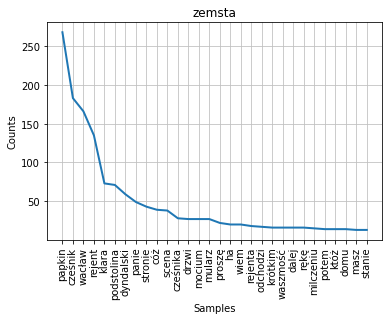

Prawo Zipfa:
 r*f=[268, 366, 498, 540, 365, 426, 413, 392, 387, 390, 418, 336, 351, 378, 405, 352, 340, 360, 342, 340, 336, 352, 368, 384, 375, 364, 378, 392, 377, 390]
 average=379.43333333333334


In [2]:
import nltk
import requests

nltk.download('punkt')

# Załadowanie stoplisty dla języka polskiego
r = requests.get('https://raw.githubusercontent.com/bieli/stopwords/master/polish.stopwords.txt')
stop_words = r.text.splitlines()

# Definicja tokenizera dla języka polskiego
def tokenize_pl(doc):
  words = nltk.word_tokenize(doc.lower(), language="polish")  # Wyodrębnienie słów z dokumentu i zamiana wszystkich liter na małe
  tokens = [word for word in words if word.isalpha() and word not in stop_words]  # Wykluczenie słów znajdujących się w stoplist oraz słów nieskładających się tylko i wyłącznie z liter alfabetu
  return tokens

# Wizualizacja częstości występowania tokenów dla każdego dokumentu z korpusu
for i in range(len(documents)):
  doc = documents[i]
  tokens = tokenize_pl(doc)
  freq = nltk.FreqDist(tokens)
  freq.plot(30, cumulative=False, title=list(corpus.keys())[i])
  # Prawo Zipfa
  freq_list = freq.most_common(30)
  zipf_constans = [freq_list[i][1]*(i+1) for i in range(len(freq_list))]
  average = sum(zipf_constans)/len(zipf_constans)
  print(f"Prawo Zipfa:\n r*f={zipf_constans}\n average={average}")


Prawo Zipfa to zasada, która mówi, że iloczyn częstotliwości i rangi słów jest stały.

Równanie prawa Zipfa: 

    r*f=constans

, gdzie:
r - ranga słowa;
f - częstotliwość występowania słowa;

Dla dokumentów z korpusu Prawo Zipfa zachodzi tylko dla dokumentu 'zemsta'. Stała wartość iloczyn wynosi tam ok. 380.

Dla pozostałych pozycji z korpusu Prawo Zipfa nie zachodzi ponieważ rozrzut wartości iloczynów jest zbyt duży.

3) Budowanie macierzy TFIDF na podstawie dokumnetów z korpusu:

In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Budowanie macierzy TFIDF
vectorizer = TfidfVectorizer(smooth_idf=False, stop_words=stop_words, tokenizer=tokenize_pl)
tfidf = vectorizer.fit_transform(documents)  # Utworzenie rzadkiej macierzy TFIDF
tfidf_dense = tfidf.todense()  # Utworzenie gęstej macierz TFIDF

# Wizualizacja zbudowanej macierzy za pomocą pandas.DataFrame
target_df = pd.DataFrame(data = corpus.keys(), columns = ['target'])  # Kolumna z nazwami dokumentów
tfidf_dense_list = tfidf_dense.tolist()
feature_names = vectorizer.get_feature_names()
tfidf_df = pd.DataFrame(tfidf_dense_list, columns=feature_names)
final_tfidf_df = pd.concat([target_df, tfidf_df], axis = 1)
print(final_tfidf_df)


          target        aa  abecadło  ...       żąć   żłopają    żłopią
0  boska-komedia  0.000000  0.004565  ...  0.000000  0.000000  0.000000
1        kordian  0.000000  0.000000  ...  0.000000  0.000000  0.000000
2   przedwiosnie  0.000000  0.000000  ...  0.001695  0.000000  0.000000
3         wesele  0.002771  0.000000  ...  0.000000  0.002771  0.002771
4         zemsta  0.000000  0.000000  ...  0.000000  0.000000  0.000000

[5 rows x 35953 columns]


4) Budowanie macierzy odległości dokumentów

In [4]:
# Budowanie macierzy odległości dokumentów
cos_sim_matrix = (tfidf_dense * tfidf_dense.T)  # Wykorzystuję fakt, że wektory w każdym wierszu macierzy TFIDF są już znormalizowane

# Wizualizacja macierzy odległości dokumentów za pomocą pandas.DataFrame
cos_sim_df = pd.DataFrame(data = cos_sim_matrix, columns = corpus.keys())
final_cos_sim_df = pd.concat([target_df, cos_sim_df], axis = 1)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  print(final_cos_sim_df)


          target  boska-komedia   kordian  przedwiosnie    wesele    zemsta
0  boska-komedia       1.000000  0.150431      0.187523  0.073748  0.040828
1        kordian       0.150431  1.000000      0.099841  0.065467  0.030595
2   przedwiosnie       0.187523  0.099841      1.000000  0.075926  0.032825
3         wesele       0.073748  0.065467      0.075926  1.000000  0.025010
4         zemsta       0.040828  0.030595      0.032825  0.025010  1.000000


5) Redukcja wymiarowości macierzy TFIDF oraz wizualiacja położenia dokumnetów na układzie współrzędnych

          target  principal component 1  principal component 2
0  boska-komedia              -0.363012              -0.240523
1        kordian              -0.248435              -0.148644
2   przedwiosnie              -0.334121              -0.158433
3         wesele               0.105075               0.866761
4         zemsta               0.840492              -0.319160


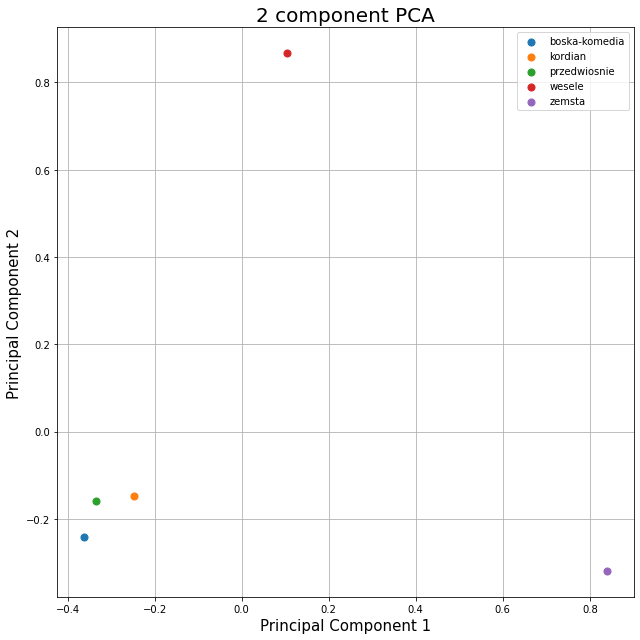

          target  boska-komedia   kordian  przedwiosnie    wesele    zemsta
0  boska-komedia       0.000000  0.146866      0.087026  1.202157  1.206070
1        kordian       0.146866  0.000000      0.086243  1.075182  1.102197
2   przedwiosnie       0.087026  0.086243      0.000000  1.115309  1.185558
3         wesele       1.202157  1.075182      1.115309  0.000000  1.395438
4         zemsta       1.206070  1.102197      1.185558  1.395438  0.000000


In [5]:
import math
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from sklearn.decomposition import PCA

# Redukcja wymiarowości macierzy TFIDF
pca = PCA(n_components=2)
principal_components = pca.fit_transform(tfidf_dense)
# Wizualizacja zredukowanej macierzy za pomocą pandas.DataFrame
principal_df = pd.DataFrame(data = principal_components, columns = ['principal component 1', 'principal component 2'])
final_principal_df = pd.concat([target_df, principal_df], axis = 1)
print(final_principal_df)

# Wizualizacjia położenia dokumentów na układzie współrzędnych
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = corpus.keys()
colors = colors.TABLEAU_COLORS
for target, color in zip(targets, colors):
    indices_to_keep = final_principal_df['target'] == target
    ax.scatter(final_principal_df.loc[indices_to_keep, 'principal component 1'],
               final_principal_df.loc[indices_to_keep, 'principal component 2'],
               c = color,
               s = 50)
ax.legend(targets)
ax.grid()
plt.tight_layout()
plt.show()

# Zbudowanie macierzy długości wektorów
n = len(principal_components)
vector_length_matrix = np.zeros((n, n))
for i in range(n):
  for j in range(n):
    x = principal_components[i][0]-principal_components[j][0]
    y = principal_components[i][1]-principal_components[j][1]
    vector_length = math.sqrt(x*x+y*y)
    vector_length_matrix[i][j] = vector_length

# Wizualizacja macierzy długości wektorów za pomocą pandas.DataFrame
vector_length_df = pd.DataFrame(data = vector_length_matrix, columns = corpus.keys())
final_vector_length_df = pd.concat([target_df, vector_length_df], axis = 1)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  print(final_vector_length_df)


6) Komentarz do wyników z punktów: 4 i 5

Wyniki z punktów: 4 oraz 5 są ze zobą spójne.
W obu pondpunktach uzyskano, iż najbardziej podobne są do siebie te same dokumenty.

W podpunkcie 4 korzystano z cosinus-owej miary podobieństwa, która która zwraca tym większą liczbę im bardziej podobne są do siebie dokumenty - dla identycznych dokumentów zwraca wartość 1.
W podpunkcie 5 korzystano z miary odmienności, która zwraca tym większą liczbę im bardziej różne są do siebie dokumenty - dla identycznych dokumentów zwraca wartość 0.

Najbardziej odmiennymi względem siebie dokumentami okazały się: 'wesele' oraz 'zemsta'. Miara podobieństwa z podpunktu 4 wskazała dla tych dokumentów wartość zaledwie: 0.025010 (najmniejsza wartość z macierzy odległości dokumentów), podczas gdy miara odmienności z podpunktu 5 wskazała dla tych dokumentów wartość aż: 1.395438 (największa wartość z macierzy długości wektorów). Wyniki te są spójne.